In [45]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import math

# for animations
import os
import glob
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [2]:
# 1. Functions to find flux at equilibrium and fixed points (+ stability analysis)

# defined as phi(f, R, Delta) in Stommel's original paper
def f_flux_1(x, R, Lambda, Delta):
    tmp_1 = (-1) / (1 + abs(x))
    tmp_2 = R / (1 + (abs(x) / Delta))
    tmp_3 = (-1) * x
    return tmp_1 + tmp_2

# defined as Lambda * f in Stommel's original paper
def f_flux_2(x, R, Lambda, Delta):
    return Lambda * x

# for each point, check if stable or not
def check_stability_fixed_point_stommel_model(f, x, y, R, Delta, Lambda):
    if f > 0:
        Tr = (-1 - Delta) - (3 / Lambda) * (- y + R * x)
        det = Delta + (1 / Lambda) * ((- y * (1 + 2 * Delta)) + (R * x * (2 + Delta)) + ((2 / Lambda) * (-y + R * x)**2))
    else:
        Tr = (-1 - Delta) + (3 / Lambda) * (- y + R * x)
        det = Delta + (1 / Lambda) * ((y * (1 + 2 * Delta)) - (R * x * (2 + Delta)) + ((2 / Lambda) * (-y + R * x)**2))
    
    if det < 0:
        return Tr, det, "saddle node"
    if det == 0 or (det > 0 and Tr == 0):
        return Tr, det, "NA"
    # now det > 0
    if Tr > 0:
        # unstable
        if (Tr**2)/4 > det:
            return Tr, det, "unstable node"
        else:
            return Tr, det, "unstable spiral"
    else: # Tr < 0
        # stable
        if (Tr**2)/4 > det:
            return Tr, det, "stable node"
        else:
            return Tr, det, "stable spiral"
    
def stability_analysis(R, Lambda, Delta, min_f, max_f, range_float, output_file_plot):
    # grafically get the flux at equilibria points
    f = np.array([f_val / range_float for f_val in range(int(min_f*range_float), int((max_f)*range_float + 1))])
    
    # calculate the curves
    y_1 = np.array([f_flux_1(f_val, R, Lambda, Delta) for f_val in f])
    y_2 = np.array([f_flux_2(f_val, R, Lambda, Delta) for f_val in f])
    
    # now find f value(on the x-axis) at the intersections
    idx_f = np.argwhere(np.diff(np.sign(y_1 - y_2))).flatten()
    f_eq = [f[idx_val] for idx_val in idx_f]
    y_f_eq = [y_1[idx_val] for idx_val in idx_f]
    
    # find x and y values correcponding to different values of flux at quilibrium
    x_eq = []
    y_eq = []
    for f_val in f_eq:
        x_eq.append(1/(1 + (abs(f_val)/Delta)))
        y_eq.append(1/(1 + abs(f_val)))
    
    stability = []
    # check stability and display results
    for i in range(len(f_eq)):
        print("Fixed point %i:\nflux = %0.5f, x = %0.5f, y = %0.5f"%(i+1, f_eq[i], x_eq[i], y_eq[i]))
        Tr, det, fixed_point_type = check_stability_fixed_point_stommel_model(f_eq[i], x_eq[i], y_eq[i], R, Delta, Lambda)
        stability.append(fixed_point_type)
        print("Trace = %0.2f, Determinant = %0.2f"%(Tr, det))
        print("Type: %s\n"%(fixed_point_type))
    
    return x_eq, y_eq, f_eq, stability


In [3]:
# 2. Functions to plot phase plane (plot parametric curves using Euler integration)

# function to integrate with the Euler method (numerical method)
def Euler_integrate(x, dt, func, args):
    return x + func(x, args) * dt

# defined as dy/dt in Stommel's original paper
def dy(y, args):
    x = args[0]
    Lambda = args[1]
    R = args[2]
    return 1 - y - (y/Lambda) * np.abs(-y + R*x)

# defined as dx/dt in Stommel's original paper
def dx(x, args):
    y = args[0]
    Lambda = args[1]
    R = args[2]
    Delta = args[3]
    return Delta * (1 - x) - (x/Lambda) * np.abs(-y + R*x)

# create and store parametric curves with different starting points
def create_curves(interval, min_x, min_y, x_y_range, n_timesteps, dt):
    # create starting points of all curves
    start_x = np.arange(min_x, min_x + x_y_range + interval, interval) 
    start_y = np.array([min_y] * start_x.shape[0]) # np.zeros(start_x.shape)
    start_x = np.concatenate((start_x, start_x))
    start_y = np.concatenate((start_y, np.array([min_y + x_y_range] * start_y.shape[0]), np.arange(min_y + interval, min_y + x_y_range, interval), np.arange(min_y + interval, min_y + x_y_range, interval)))
    start_x = np.concatenate((start_x, np.array([min_x] * (int((start_x.shape[0] - 4)/2))), np.array([min_x + x_y_range] * (int((start_x.shape[0] - 4)/2)))))
    # print(start_x, len(start_x))
    # print(start_y, len(start_y))
    
    # will store all curves
    x = []
    y = []
    
    # compute all curves with Euler method
    for ind_traj in range(len(start_x)):
        x_1 = [None] * n_timesteps
        y_1 = [None] * n_timesteps
        x_1[0] = start_x[ind_traj]
        y_1[0] = start_y[ind_traj]
        for t in range(1, n_timesteps):
            x_tmp = x_1[t-1]
            y_tmp = y_1[t-1]
            args_x = (y_tmp, Lambda, R, Delta)
            args_y = (x_tmp, Lambda, R)
            x_1[t] = Euler_integrate(x_tmp, dt, dx, args_x)
            y_1[t] = Euler_integrate(y_tmp, dt, dy, args_y)
        x.append(x_1)
        y.append(y_1)
    # print(len(x))
    # print(len(y))
    return x, y

def create_direction_field(nx, ny):
    # create the grid
    x_g = np.arange(0, 1+nx, nx)
    y_g = np.arange(0, 1+nx, ny)
    X, Y  = np.meshgrid(x_g, y_g)

    # assign values for direction field at each point of the grid
    dy_g = 1 - Y - (Y/Lambda) * np.abs(-Y + R*X)
    dx_g = Delta * (1 - X) - (X/Lambda) * np.abs(-Y + R*X)
    
    # normalize
    dyu_g = dy_g/np.sqrt(dx_g**2 + dy_g**2)
    dxu_g = dx_g/np.sqrt(dx_g**2 + dy_g**2)
    
    return X, Y, dyu_g, dxu_g


In [26]:
# functions for animation

def create_empty_folder(folder):
    if os.path.exists(folder):
        files = glob.glob(folder + '/*')
        for f in files:
            os.remove(f)
    else:
        os.mkdir(folder)

        
# create animation with moviepy library
def create_animation(folder_path, x, y, X, Y, dyu_g, dxu_g, x_eq, y_eq, n_timesteps, fps, output_file):
    # create folder in which we will store all images and the animation
    tmp_folder = folder_path + "/tmp"
    if os.path.exists(tmp_folder):
        files = glob.glob(tmp_folder + '/*')
        for f in files:
            os.remove(f)
    else:
        os.mkdir(tmp_folder)
    
    # create the individual images
    for nt in range(1, n_timesteps + 1):
    
        # create figure and save image
        plt.figure(dpi = 200)

        for ind in range(len(x)):
            if ind % 10 == 0:
                plt.plot(x[ind][:nt], y[ind][:nt], linewidth = 0.5, c = 'black', alpha = 1, zorder=1)
            else:
                plt.plot(x[ind][:nt], y[ind][:nt], linewidth = 0.5, c = 'r', alpha = 0.5, zorder=1)
        
        plt.quiver(X, Y, dxu_g, dyu_g, color = 'k', zorder = 2)
        for i in range(len(x_eq)):
            plt.scatter(x_eq[i], y_eq[i], alpha = 1, c = 'w', edgecolors = 'k', linewidth=0.8, zorder=3, s = 8) 
        plt.margins(x = 0, y = 0)
        plt.xticks(fontsize=7)
        plt.xlabel("x (non-dimensional salinity)", fontsize=7)
        plt.ylabel("y (non-dimensional temperature)", fontsize=7)
        plt.yticks(fontsize=7)
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        plt.savefig(tmp_folder + "/" + str(nt) + ".png")
        plt.close()
        # plt.show()
        
    # create animation 
    file_list = np.array(sorted(glob.glob(tmp_folder + '/*.png')))
    order = np.array([int(f.split("/")[-1].split(".")[0]) for f in file_list])
    sortIx = np.argsort(order)
    file_list = list(file_list[sortIx])

    clip = mpy.ImageSequenceClip(file_list, fps=fps)
    clip.write_videofile(folder_path + "/" + output_file)   

## Model 1: 3 quilibrium points

In [70]:
# parameters related to the model
R = 2
Lambda = 1/5
Delta = 1/6

# parameters to plot flux and show flux values at equilibrium points
min_f = -2.5
max_f = 2.5
range_float = 1000.0
output_file_plot_flux = "outputs/1_equilibrium_flux.png"

# parameters to plot phase plane
# parametric curves
interval = 0.01 # interval between each x and y of curves' starting points
min_x = 0
min_y = 0
x_y_range = 1
n_timesteps = 700
dt = 0.01
# direction field
nx = 0.04
ny = 0.04
output_file_phase_plane = "outputs/1_phase_plane.png"

# output_file_phase_plane = "outputs/1_phase_plane.png"
folder_animation = "outputs"
fps = 20
n_timesteps_animation = 400
animation_file = "1_animation.mp4"

Fixed point 1:
flux = -1.06800, x = 0.13499, y = 0.48356
Trace = -4.37, Determinant = 2.75
Type: stable node

Fixed point 2:
flux = -0.30800, x = 0.35112, y = 0.76453
Trace = -2.10, Determinant = -2.15
Type: saddle node

Fixed point 3:
flux = 0.21900, x = 0.43215, y = 0.82034
Trace = -1.83, Determinant = 4.16
Type: stable spiral



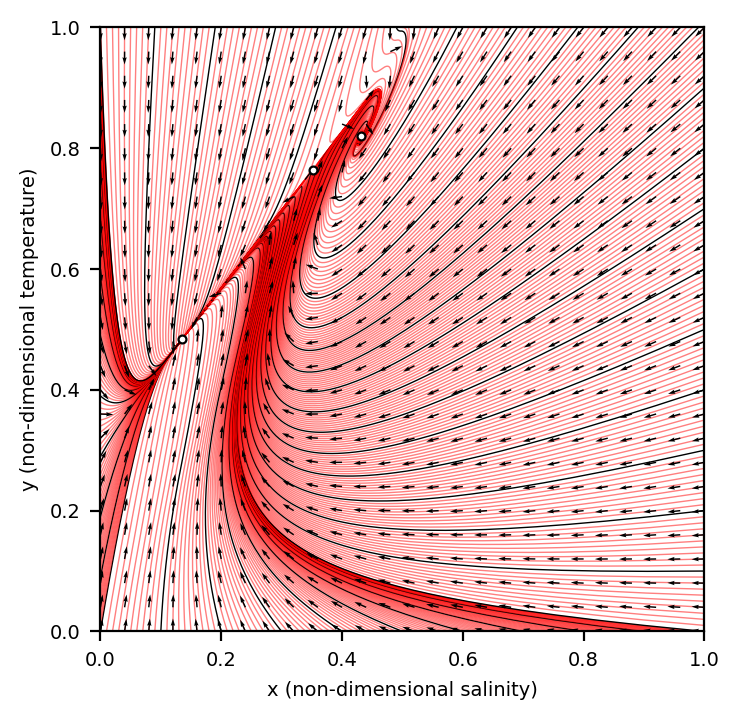

In [64]:
x_eq, y_eq, f_eq, stability = stability_analysis(R, Lambda, Delta, min_f, max_f, range_float, output_file_plot_flux)

x, y = create_curves(interval, min_x, min_y, x_y_range, n_timesteps, dt)
X, Y, dyu_g, dxu_g = create_direction_field(nx, ny)

create_animation(folder_animation, x, y, X, Y, dyu_g, dxu_g, x_eq, y_eq, n_timesteps_animation, fps, animation_file)

# display last image
plt.figure(dpi = 200)

for ind in range(len(x)):
    if ind % 10 == 0:
        plt.plot(x[ind], y[ind], linewidth = 0.5, c = 'black', alpha = 1, zorder=1)
    else:
        plt.plot(x[ind], y[ind], linewidth = 0.5, c = 'r', alpha = 0.5, zorder=1)
plt.quiver(X, Y, dxu_g, dyu_g, color = 'k', zorder = 2)
for i in range(len(x_eq)):
    plt.scatter(x_eq[i], y_eq[i], alpha = 1, c = 'w', edgecolors = 'k', linewidth=0.8, zorder=3, s = 8) 
plt.margins(x = 0, y = 0)
plt.xticks(fontsize=7)
plt.xlabel("x (non-dimensional salinity)", fontsize=7)
plt.ylabel("y (non-dimensional temperature)", fontsize=7)
plt.yticks(fontsize=7)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig(output_file_phase_plane)
plt.show()

## Model 2: 1 quilibrium point

In [74]:
# parameters related to the model
R = 2
Lambda = 1/5
Delta = 1

# parameters to plot flux and show flux values at equilibrium points
min_f = -2.5
max_f = 2.5
range_float = 1000.0
output_file_plot_flux = "outputs/2_equilibrium_flux.png"

# parameters to plot phase plane
# parametric curves
interval = 0.01 # interval between each x and y of curves' starting points
min_x = 0
min_y = 0
x_y_range = 1
n_timesteps = 700
dt = 0.01
# direction field
nx = 0.04
ny = 0.04
output_file_phase_plane = "outputs/2_phase_plane.png"

# output_file_phase_plane = "outputs/1_phase_plane.png"
folder_animation = "outputs"
fps = 20
n_timesteps_animation = 200
animation_file = "2_animation.mp4"

n_timesteps_traj = 1500

Fixed point 1:
flux = 1.79100, x = 0.35829, y = 0.35829
Trace = -7.37, Determinant = 12.79
Type: stable node

Moviepy - Building video outputs/2_animation.mp4.
Moviepy - Writing video outputs/2_animation.mp4



Moviepy - Done !
Moviepy - video ready outputs/2_animation.mp4


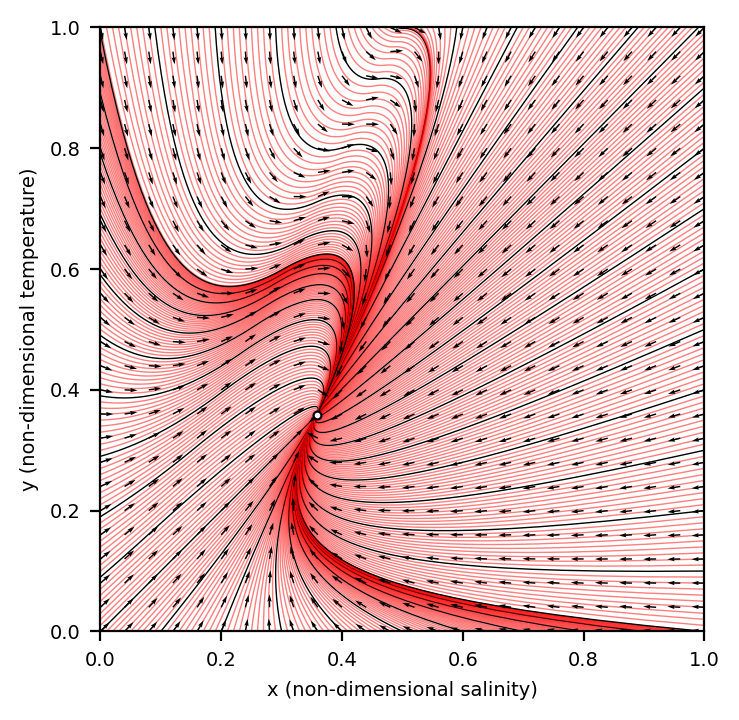

In [75]:
x_eq, y_eq, f_eq, stability = stability_analysis(R, Lambda, Delta, min_f, max_f, range_float, output_file_plot_flux)

x, y = create_curves(interval, min_x, min_y, x_y_range, n_timesteps, dt)
X, Y, dyu_g, dxu_g = create_direction_field(nx, ny)

create_animation(folder_animation, x, y, X, Y, dyu_g, dxu_g, x_eq, y_eq, n_timesteps_animation, fps, animation_file)

# display last image
plt.figure(dpi = 200)

for ind in range(len(x)):
    if ind % 10 == 0:
        plt.plot(x[ind], y[ind], linewidth = 0.5, c = 'black', alpha = 1, zorder=1)
    else:
        plt.plot(x[ind], y[ind], linewidth = 0.5, c = 'r', alpha = 0.5, zorder=1)
plt.quiver(X, Y, dxu_g, dyu_g, color = 'k', zorder = 2)
for i in range(len(x_eq)):
    plt.scatter(x_eq[i], y_eq[i], alpha = 1, c = 'w', edgecolors = 'k', linewidth=0.8, zorder=3, s = 8) 
plt.margins(x = 0, y = 0)
plt.xticks(fontsize=7)
plt.xlabel("x (non-dimensional salinity)", fontsize=7)
plt.ylabel("y (non-dimensional temperature)", fontsize=7)
plt.yticks(fontsize=7)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig(output_file_phase_plane)
plt.show()